In [23]:
import numpy as np
import pandas as pd
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# import pmdarima as pm

In [5]:
# %pip install statsmodels

In [ ]:
# Fetch the data time series for productSKU 'B33_S3' and Customer segment = 0


In [6]:
def generate_data(n=100, seed=42):
    """
    Generate synthetic time series data with exogenous variables.
    
    Parameters:
    n (int): Number of data points.
    seed (int): Seed for reproducibility.
    
    Returns:
    pd.DataFrame: DataFrame containing the endogenous and exogenous variables.
    """
    np.random.seed(seed)
    Y = np.cumsum(np.random.randn(n))  # Random walk
    X1 = np.random.randn(n)
    X2 = np.random.randn(n)
    data = pd.DataFrame({'Y': Y, 'X1': X1, 'X2': X2}, index=pd.date_range(start='2020-01-01', periods=n))
    return data

In [22]:
def fit_arimax(data, order=(1, 1, 1), exog_cols=['X1', 'X2'], forecast_steps=10):
    """
    Fit an ARIMAX model to the data and make forecasts.
    
    Parameters:
    data (pd.DataFrame): DataFrame containing the time series and exogenous variables.
    order (tuple): The (p,d,q) order of the ARIMA model.
    exog_cols (list): List of column names for the exogenous variables.
    forecast_steps (int): Number of steps to forecast.
    
    Returns:
    pd.DataFrame: DataFrame containing the observed, forecasted values, and confidence intervals.
    """
    exog = data[exog_cols]
    model = SARIMAX(data['Y'], exog=exog, order=order)
    results = model.fit()
    print(results.summary())

    forecast = results.get_forecast(steps=forecast_steps, exog=np.random.randn(forecast_steps, len(exog_cols)))
    forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()

    forecast_df = pd.DataFrame({'Forecast': forecast_mean}, index=forecast_index)
    forecast_df['Lower CI'] = forecast_ci.iloc[:, 0]
    forecast_df['Upper CI'] = forecast_ci.iloc[:, 1]
    
    return forecast_df

In [8]:
import matplotlib.pyplot as plt

def plot_results(data, forecast_df):
    """
    Plot the observed data and forecasted values.
    
    Parameters:
    data (pd.DataFrame): DataFrame containing the observed time series.
    forecast_df (pd.DataFrame): DataFrame containing the forecasted values and confidence intervals.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Y'], label='Observed')
    plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast')
    plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], color='pink', alpha=0.3)
    plt.legend()
    plt.title('ARIMAX Model Forecast')
    plt.show()

                               SARIMAX Results                                
Dep. Variable:                      Y   No. Observations:                  100
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -130.335
Date:                Mon, 14 Oct 2024   AIC                            270.669
Time:                        16:31:17   BIC                            283.645
Sample:                    01-01-2020   HQIC                           275.919
                         - 04-09-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
X1            -0.0031      0.063     -0.048      0.961      -0.128       0.121
X2             0.0838      0.060      1.398      0.162      -0.034       0.201
ar.L1          0.4536      7.447      0.061      0.9

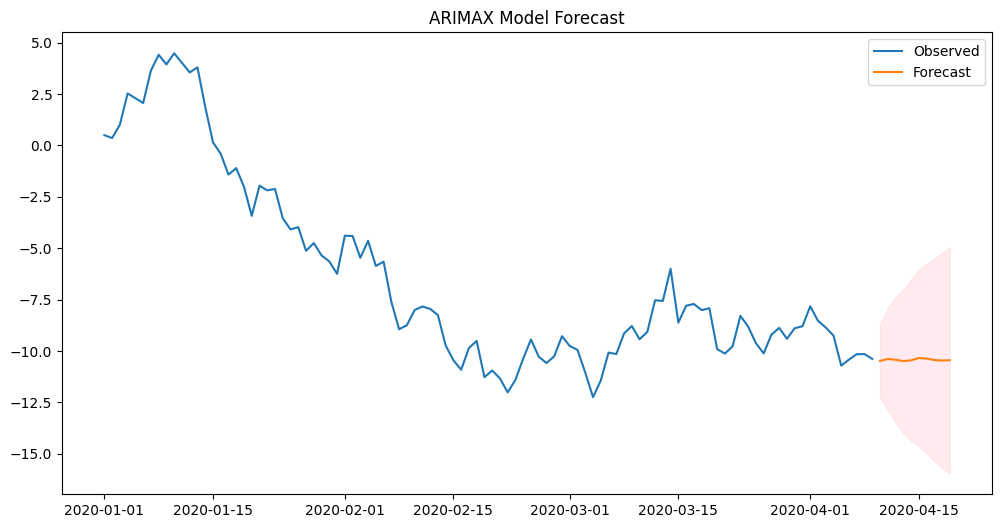

In [9]:
data = generate_data()

# Fit ARIMAX model and forecast
forecast_df = fit_arimax(data, order=(1, 1, 1), exog_cols=['X1', 'X2'], forecast_steps=10)

# Plot the results
plot_results(data, forecast_df)

                               SARIMAX Results                                
Dep. Variable:                      Y   No. Observations:                  100
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -130.335
Date:                Mon, 14 Oct 2024   AIC                            270.669
Time:                        16:31:18   BIC                            283.645
Sample:                    01-01-2020   HQIC                           275.919
                         - 04-09-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
X1            -0.0031      0.063     -0.048      0.961      -0.128       0.121
X2             0.0838      0.060      1.398      0.162      -0.034       0.201
ar.L1          0.4536      7.447      0.061      0.9

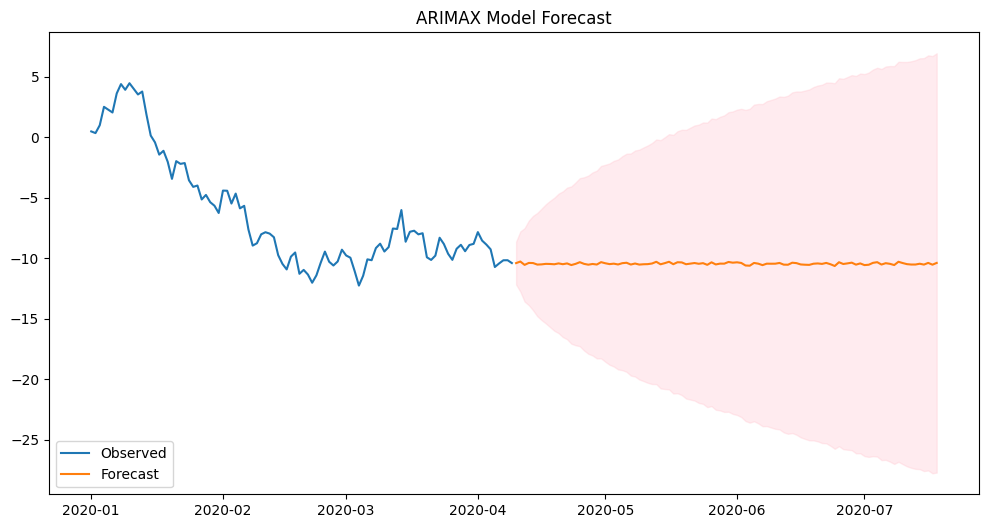

In [10]:
forecast_df = fit_arimax(data, order=(1, 1, 1), exog_cols=['X1', 'X2'], forecast_steps=100)

# Plot the results
plot_results(data, forecast_df)

Data Collection

Because we want to predict the demand regardless of the price so we will take only ```Date``` and ```UNITS_SOLD```

In [11]:
from dotenv import load_dotenv
import os
import json
import sys
# import cachetools

#import Snowflake modules
from snowflake.snowpark import Session
# import snowflake.snowpark.function as F
import snowflake.snowpark.types as T
# Do insert with Credentials in .env instead

In [12]:
load_dotenv()

# Connect to Snowflake
USER = os.getenv("SNOWFLAKE_USER")
PASSWORD = os.getenv("SNOWFLAKE_PASSWORD")
ACCOUNT = os.getenv("SNOWFLAKE_ACCOUNT")
WAREHOUSE = os.getenv("SNOWFLAKE_WAREHOUSE")
DATABASE = os.getenv("SNOWFLAKE_DATABASE")
SCHEMA = os.getenv("SNOWFLAKE_SCHEMA")
ROLE = os.getenv("SNOWFLAKE_ROLE")

In [13]:
connection_parameters = {
    "account": ACCOUNT,
    "user": USER,
    "password": PASSWORD,
    "role": ROLE,
    "warehouse": WAREHOUSE,
    "database": DATABASE,
    "schema": SCHEMA,
}

# create Snowpark session
session = Session.builder.configs(connection_parameters).create()

c:\Users\panha.vuthy\AppData\Local\Programs\Python\Python311\Lib\site-packages\snowflake\connector\config_manager.py:351: UserWarning: Bad owner or permissions on C:\Users\panha.vuthy\AppData\Local\snowflake\config.toml
  warn(f"Bad owner or permissions on {str(filep)}{chmod_message}")


In [14]:
import pandas as pd

In [15]:
product_sku = "B33_S3"
data_collection = session.sql(f"""
SELECT 
    FACT_ORDER_LINE_ITEM_BASE.ORDER_DATE AS "DATE",
    REL_CUS_SEGMENTATION_RFM.CLUSTER AS "CUSTOMER_SEGMENT",
    SUM(FACT_ORDER_LINE_ITEM_BASE.ORDERED_QUANTITY) AS "UNITS_SOLD",
FROM 
    LU_PRD_PRODUCT_SKU
JOIN 
    LU_PRD_PRODUCT
ON 
    LU_PRD_PRODUCT_SKU.PRODUCT_SKU = LU_PRD_PRODUCT.PRODUCT_SKU
JOIN 
    FACT_ORDER_LINE_ITEM_BASE 
ON 
    FACT_ORDER_LINE_ITEM_BASE.PRODUCT_CODE = LU_PRD_PRODUCT.PRODUCT_CODE
JOIN 
    LU_CUS_CUSTOMER 
ON
    LU_CUS_CUSTOMER.CUSTOMER_CODE = FACT_ORDER_LINE_ITEM_BASE.CUSTOMER_CODE
JOIN 
    REL_CUS_SEGMENTATION_RFM
ON
    REL_CUS_SEGMENTATION_RFM.CUSTOMER_CODE = FACT_ORDER_LINE_ITEM_BASE.CUSTOMER_CODE
WHERE
    LU_PRD_PRODUCT_SKU.PRODUCT_SKU IN  ('{product_sku}')
    AND (YEAR(FACT_ORDER_LINE_ITEM_BASE.ORDER_DATE) BETWEEN 2021 AND 2023)
GROUP BY
    DATE, CUSTOMER_SEGMENT
ORDER BY
    DATE ASC
""").collect()

In [16]:
data_frame = pd.DataFrame(data_collection)

In [17]:
data_frame.head()

,DATE,CUSTOMER_SEGMENT,UNITS_SOLD
0,2021-01-01,2,30.00
1,2021-01-01,0,150.00
2,2021-01-02,1,105.00
3,2021-01-02,0,35.00
4,2021-01-03,1,18.00


In [18]:
%pip install pmdarima

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python311.exe -m pip install --upgrade pip


In [19]:
data_frame['DATE'] = pd.to_datetime(data_frame['DATE'])

In [20]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data_frame, test_size=0.2, shuffle=False)
X_train = train_set.drop(columns='UNITS_SOLD')
y_train = train_set['UNITS_SOLD']
X_test = test_set.drop(columns='UNITS_SOLD')
y_test = test_set['UNITS_SOLD']

In [21]:
import numpy as np
print(np.__version__)

1.26.4
